In [10]:
import os
import gc
import cv2
import glob
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import wandb
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')
print(f"PyTorch: {torch.__version__}, GPU: {torch.cuda.is_available()}")


PyTorch: 2.6.0+cu124, GPU: True


In [11]:
class CFG:
    # Paths and Directories
    BASE_PATH = "/kaggle/input/200-gold-standard-adni/200_AD_CN_MCI_11112025"
    CSV_PATH  = "/kaggle/input/metadatafor200gd/metadata.csv"
    OUTPUT_DIR = "/kaggle/working/outputs/" # NEW: Central directory for all outputs

    # Experiment
    project_name = "Alzheimers_Seg_KFold_Enhanced"
    run_name = "Unet++_EfficientNetB0_Lovasz_Scheduler"
    seed = 42

    # Model
    arch = "UnetPlusPlus"
    backbone = "efficientnet-b0"
    weights = "imagenet"

    # Training
    n_folds = 5
    img_size = 256
    batch_size = 16
    epochs = 50
    lr = 1e-4
    
    # NEW: Scheduler Parameters
    scheduler_T_max = epochs
    scheduler_min_lr = 1e-6

    # NEW: Gradient Clipping
    max_grad_norm = 1000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 2

# Create output directory
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)

In [12]:
# 3. WANDB LOGIN
# ====================================================
from kaggle_secrets import UserSecretsClient
try:
    user_secrets = UserSecretsClient()
    wandb.login(key=user_secrets.get_secret("wandb_api"))
    print("✅ Logged into WandB")
except:
    print("Could not log into WandB. Using offline mode.")
    wandb.init(mode="disabled")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


✅ Logged into WandB


In [13]:
def get_data():
    df = pd.read_csv(CFG.CSV_PATH)
    df['image_path'] = df['image_id'].apply(lambda x: os.path.join(CFG.BASE_PATH, 'images', x))
    df['mask_path'] = df['mask_id'].apply(lambda x: os.path.join(CFG.BASE_PATH, 'masks', x))
    df['class'] = df['image_id'].apply(lambda x: x.split('_')[0].upper())
    print(f"Total Images: {len(df)}")
    return df

df_all = get_data()

Total Images: 200


In [15]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 127, 1.0, 0.0)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        if mask.ndim == 2: mask = mask.unsqueeze(0)
        return img, mask.float()

def get_transforms(data):
    # Same robust augmentations
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.img_size, CFG.img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.OneOf([
                A.GridDistortion(p=1.0), A.ElasticTransform(p=1.0)
            ], p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.img_size, CFG.img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

In [16]:
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CFG.backbone, encoder_weights=CFG.weights,
        in_channels=3, classes=1, activation=None
    )
    return model.to(CFG.device)

dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
lovasz_loss = smp.losses.LovaszLoss(mode='binary', per_image=True, from_logits=True)
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

def criterion(y_pred, y_true):
    # A common stable combination
    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * lovasz_loss(y_pred, y_true)

In [17]:
# 7. TRAINING & VALIDATION ENGINE (ENHANCED)
# ====================================================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(loader, desc="Train"):
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        optimizer.zero_grad()
        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, masks)
        scaler.scale(loss).backward()
        # NEW: Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    return running_loss / len(loader)

@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_masks = [], []
    
    for images, masks in tqdm(loader, desc="Valid"):
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        logits = model(images)
        loss = criterion(logits, masks)
        running_loss += loss.item()
        
        preds = (logits.sigmoid() > 0.5).long()
        all_preds.append(preds.cpu())
        all_masks.append(masks.cpu().long())

    # Calculate metrics on all validation data at once
    all_preds_cat = torch.cat(all_preds)
    all_masks_cat = torch.cat(all_masks)
    
    tp, fp, fn, tn = smp.metrics.get_stats(all_preds_cat, all_masks_cat, mode='binary')
    
    # NEW: Expanded metrics
    metrics = {
        "loss": running_loss / len(loader),
        "dice": smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item(),
        "iou": smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item(),
        "precision": smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item(),
        "recall": smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item(),
    }
    
    return metrics, all_preds_cat


In [18]:
# 8. K-FOLD TRAINING LOOP (ENHANCED)
# ====================================================
def run_kfold():
    skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    
    final_scores = []
    fold_histories = []
    oof_predictions = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_all, df_all['class'])):
        print(f"\n{'='*15} FOLD {fold+1}/{CFG.n_folds} {'='*15}")
        wandb.init(project=CFG.project_name, name=f"Fold_{fold+1}", group=CFG.run_name, reinit=True)

        train_df, valid_df = df_all.iloc[train_idx], df_all.iloc[val_idx]
        
        train_loader = DataLoader(BrainDataset(train_df, get_transforms('train')), **train_params)
        valid_loader = DataLoader(BrainDataset(valid_df, get_transforms('valid')), **valid_params)

        model = build_model()
        optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
        # NEW: Learning Rate Scheduler
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.scheduler_T_max, eta_min=CFG.scheduler_min_lr)
        scaler = amp.GradScaler()

        best_dice = -1
        history = {'train_loss': []}
        
        for epoch in range(CFG.epochs):
            print(f"Epoch {epoch+1}/{CFG.epochs}")
            t_loss = train_one_epoch(model, train_loader, optimizer, scaler)
            val_metrics, preds = valid_one_epoch(model, valid_loader)
            
            # Log metrics
            history['train_loss'].append(t_loss)
            for k, v in val_metrics.items():
                history.setdefault(f'val_{k}', []).append(v)
            
            wandb.log({"train_loss": t_loss, **{f'val_{k}': v for k, v in val_metrics.items()}, "lr": scheduler.get_last_lr()[0]})
            
            print(f"Loss: {t_loss:.4f} | Val Dice: {val_metrics['dice']:.4f} | Val IoU: {val_metrics['iou']:.4f}")

            # Update scheduler
            scheduler.step()
            
            if val_metrics['dice'] > best_dice:
                print(f"  -> New best score: {val_metrics['dice']:.4f}! Saving model...")
                best_dice = val_metrics['dice']
                best_epoch_metrics = val_metrics
                torch.save(model.state_dict(), f"{CFG.OUTPUT_DIR}best_dice_fold_{fold+1}.pth")
                
                # NEW: Save OOF predictions from the best epoch
                oof_for_fold = {
                    "indices": val_idx,
                    "preds": preds.numpy(), # Save as numpy array
                }

        # NEW: Save last epoch model
        torch.save(model.state_dict(), f"{CFG.OUTPUT_DIR}last_epoch_fold_{fold+1}.pth")
        
        final_scores.append(best_epoch_metrics)
        fold_histories.append(history)
        oof_predictions.append(oof_for_fold)
        
        wandb.finish()
        del model, optimizer, scheduler, train_loader, valid_loader
        gc.collect(); torch.cuda.empty_cache()

    # NEW: Save OOF predictions to a file
    np.save(f"{CFG.OUTPUT_DIR}oof_predictions.npy", oof_predictions)
    
    return final_scores, fold_histories

# Dataloader params
train_params = {'batch_size': CFG.batch_size, 'shuffle': True, 'num_workers': CFG.num_workers, 'pin_memory': True}
valid_params = {'batch_size': CFG.batch_size, 'shuffle': False, 'num_workers': CFG.num_workers, 'pin_memory': True}

final_scores, fold_histories = run_kfold()


=============== FOLD 1/5 ===============


Epoch 1/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.8063 | Val Dice: 0.2258 | Val IoU: 0.1273
  -> New best score: 0.2258! Saving model...
Epoch 2/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.4436 | Val Dice: 0.2323 | Val IoU: 0.1314
  -> New best score: 0.2323! Saving model...
Epoch 3/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.2696 | Val Dice: 0.2361 | Val IoU: 0.1339
  -> New best score: 0.2361! Saving model...
Epoch 4/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.1086 | Val Dice: 0.2368 | Val IoU: 0.1343
  -> New best score: 0.2368! Saving model...
Epoch 5/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.9867 | Val Dice: 0.2375 | Val IoU: 0.1347
  -> New best score: 0.2375! Saving model...
Epoch 6/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.8853 | Val Dice: 0.2375 | Val IoU: 0.1348
  -> New best score: 0.2375! Saving model...
Epoch 7/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.8155 | Val Dice: 0.2469 | Val IoU: 0.1408
  -> New best score: 0.2469! Saving model...
Epoch 8/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7550 | Val Dice: 0.4390 | Val IoU: 0.2812
  -> New best score: 0.4390! Saving model...
Epoch 9/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7174 | Val Dice: 0.5964 | Val IoU: 0.4249
  -> New best score: 0.5964! Saving model...
Epoch 10/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6712 | Val Dice: 0.6530 | Val IoU: 0.4847
  -> New best score: 0.6530! Saving model...
Epoch 11/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6346 | Val Dice: 0.6724 | Val IoU: 0.5065
  -> New best score: 0.6724! Saving model...
Epoch 12/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6031 | Val Dice: 0.6648 | Val IoU: 0.4979
Epoch 13/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5749 | Val Dice: 0.6694 | Val IoU: 0.5030
Epoch 14/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5580 | Val Dice: 0.6663 | Val IoU: 0.4995
Epoch 15/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5270 | Val Dice: 0.6912 | Val IoU: 0.5281
  -> New best score: 0.6912! Saving model...
Epoch 16/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5035 | Val Dice: 0.7258 | Val IoU: 0.5696
  -> New best score: 0.7258! Saving model...
Epoch 17/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4985 | Val Dice: 0.7380 | Val IoU: 0.5848
  -> New best score: 0.7380! Saving model...
Epoch 18/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4655 | Val Dice: 0.7405 | Val IoU: 0.5880
  -> New best score: 0.7405! Saving model...
Epoch 19/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4459 | Val Dice: 0.7389 | Val IoU: 0.5859
Epoch 20/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4394 | Val Dice: 0.7081 | Val IoU: 0.5481
Epoch 21/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4246 | Val Dice: 0.7703 | Val IoU: 0.6265
  -> New best score: 0.7703! Saving model...
Epoch 22/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4153 | Val Dice: 0.7672 | Val IoU: 0.6223
Epoch 23/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4169 | Val Dice: 0.8083 | Val IoU: 0.6782
  -> New best score: 0.8083! Saving model...
Epoch 24/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4074 | Val Dice: 0.8048 | Val IoU: 0.6733
Epoch 25/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4107 | Val Dice: 0.8265 | Val IoU: 0.7043
  -> New best score: 0.8265! Saving model...
Epoch 26/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3965 | Val Dice: 0.7916 | Val IoU: 0.6551
Epoch 27/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3953 | Val Dice: 0.8259 | Val IoU: 0.7034
Epoch 28/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3877 | Val Dice: 0.8383 | Val IoU: 0.7216
  -> New best score: 0.8383! Saving model...
Epoch 29/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4073 | Val Dice: 0.8304 | Val IoU: 0.7099
Epoch 30/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3846 | Val Dice: 0.8353 | Val IoU: 0.7171
Epoch 31/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3853 | Val Dice: 0.8344 | Val IoU: 0.7159
Epoch 32/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3772 | Val Dice: 0.8349 | Val IoU: 0.7166
Epoch 33/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3742 | Val Dice: 0.8364 | Val IoU: 0.7188
Epoch 34/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3749 | Val Dice: 0.8396 | Val IoU: 0.7235
  -> New best score: 0.8396! Saving model...
Epoch 35/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3776 | Val Dice: 0.8446 | Val IoU: 0.7310
  -> New best score: 0.8446! Saving model...
Epoch 36/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3718 | Val Dice: 0.8435 | Val IoU: 0.7293
Epoch 37/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3737 | Val Dice: 0.8391 | Val IoU: 0.7228
Epoch 38/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3703 | Val Dice: 0.8394 | Val IoU: 0.7233
Epoch 39/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3667 | Val Dice: 0.8438 | Val IoU: 0.7298
Epoch 40/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3600 | Val Dice: 0.8439 | Val IoU: 0.7299
Epoch 41/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3681 | Val Dice: 0.8437 | Val IoU: 0.7297
Epoch 42/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3591 | Val Dice: 0.8442 | Val IoU: 0.7304
Epoch 43/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3659 | Val Dice: 0.8442 | Val IoU: 0.7305
Epoch 44/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3618 | Val Dice: 0.8443 | Val IoU: 0.7306
Epoch 45/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3588 | Val Dice: 0.8431 | Val IoU: 0.7288
Epoch 46/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3581 | Val Dice: 0.8411 | Val IoU: 0.7258
Epoch 47/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3631 | Val Dice: 0.8391 | Val IoU: 0.7229
Epoch 48/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3583 | Val Dice: 0.8376 | Val IoU: 0.7205
Epoch 49/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3581 | Val Dice: 0.8358 | Val IoU: 0.7180
Epoch 50/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3648 | Val Dice: 0.8346 | Val IoU: 0.7162


lr,████████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▁▁▁▁▁▃▅▆▆▆▆▆▇▇▇▆▇▇██▇██████████████████
val_iou,▁▁▁▁▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇█████████████████████
val_loss,███▇▆▅▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▁▁▃▄▆▆▇▇▇██████████████████████▇▇▇▇▇
val_recall,▇████▇▅▄▃▂▂▁▁▂▂▂▁▃▄▄▃▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆
lr,0.0
train_loss,0.36483
val_dice,0.83461
val_iou,0.71617



=============== FOLD 2/5 ===============


Epoch 1/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.0868 | Val Dice: 0.1207 | Val IoU: 0.0642
  -> New best score: 0.1207! Saving model...
Epoch 2/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.8588 | Val Dice: 0.4214 | Val IoU: 0.2670
  -> New best score: 0.4214! Saving model...
Epoch 3/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7260 | Val Dice: 0.6664 | Val IoU: 0.4997
  -> New best score: 0.6664! Saving model...
Epoch 4/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6268 | Val Dice: 0.7562 | Val IoU: 0.6080
  -> New best score: 0.7562! Saving model...
Epoch 5/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5566 | Val Dice: 0.7876 | Val IoU: 0.6496
  -> New best score: 0.7876! Saving model...
Epoch 6/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5091 | Val Dice: 0.7275 | Val IoU: 0.5717
Epoch 7/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4780 | Val Dice: 0.6300 | Val IoU: 0.4598
Epoch 8/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4448 | Val Dice: 0.6191 | Val IoU: 0.4483
Epoch 9/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4323 | Val Dice: 0.5171 | Val IoU: 0.3487
Epoch 10/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4189 | Val Dice: 0.5531 | Val IoU: 0.3822
Epoch 11/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4156 | Val Dice: 0.4683 | Val IoU: 0.3058
Epoch 12/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4059 | Val Dice: 0.5068 | Val IoU: 0.3394
Epoch 13/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3920 | Val Dice: 0.5025 | Val IoU: 0.3356
Epoch 14/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3920 | Val Dice: 0.5418 | Val IoU: 0.3715
Epoch 15/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3852 | Val Dice: 0.5744 | Val IoU: 0.4029
Epoch 16/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3799 | Val Dice: 0.5744 | Val IoU: 0.4029
Epoch 17/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3757 | Val Dice: 0.6461 | Val IoU: 0.4772
Epoch 18/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3741 | Val Dice: 0.6283 | Val IoU: 0.4581
Epoch 19/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3658 | Val Dice: 0.6579 | Val IoU: 0.4902
Epoch 20/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3662 | Val Dice: 0.6572 | Val IoU: 0.4894
Epoch 21/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3620 | Val Dice: 0.6103 | Val IoU: 0.4392
Epoch 22/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3581 | Val Dice: 0.6657 | Val IoU: 0.4989
Epoch 23/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3591 | Val Dice: 0.6545 | Val IoU: 0.4864
Epoch 24/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3613 | Val Dice: 0.6941 | Val IoU: 0.5315
Epoch 25/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3501 | Val Dice: 0.6717 | Val IoU: 0.5056
Epoch 26/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3479 | Val Dice: 0.7023 | Val IoU: 0.5412
Epoch 27/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3498 | Val Dice: 0.7177 | Val IoU: 0.5597
Epoch 28/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3494 | Val Dice: 0.7393 | Val IoU: 0.5865
Epoch 29/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3436 | Val Dice: 0.7182 | Val IoU: 0.5603
Epoch 30/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3480 | Val Dice: 0.7476 | Val IoU: 0.5970
Epoch 31/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3457 | Val Dice: 0.7288 | Val IoU: 0.5733
Epoch 32/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3407 | Val Dice: 0.7512 | Val IoU: 0.6016
Epoch 33/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3419 | Val Dice: 0.7549 | Val IoU: 0.6063
Epoch 34/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3383 | Val Dice: 0.7512 | Val IoU: 0.6016
Epoch 35/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3373 | Val Dice: 0.7570 | Val IoU: 0.6090
Epoch 36/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3402 | Val Dice: 0.7599 | Val IoU: 0.6127
Epoch 37/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3390 | Val Dice: 0.7623 | Val IoU: 0.6159
Epoch 38/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3346 | Val Dice: 0.7566 | Val IoU: 0.6085
Epoch 39/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3369 | Val Dice: 0.7615 | Val IoU: 0.6149
Epoch 40/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3379 | Val Dice: 0.7658 | Val IoU: 0.6205
Epoch 41/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3326 | Val Dice: 0.7632 | Val IoU: 0.6171
Epoch 42/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3339 | Val Dice: 0.7672 | Val IoU: 0.6224
Epoch 43/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3336 | Val Dice: 0.7737 | Val IoU: 0.6309
Epoch 44/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3332 | Val Dice: 0.7711 | Val IoU: 0.6274
Epoch 45/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3366 | Val Dice: 0.7760 | Val IoU: 0.6339
Epoch 46/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3321 | Val Dice: 0.7778 | Val IoU: 0.6364
Epoch 47/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3334 | Val Dice: 0.7793 | Val IoU: 0.6385
Epoch 48/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3353 | Val Dice: 0.7816 | Val IoU: 0.6415
Epoch 49/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3344 | Val Dice: 0.7838 | Val IoU: 0.6444
Epoch 50/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3374 | Val Dice: 0.7879 | Val IoU: 0.6501
  -> New best score: 0.7879! Saving model...


lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▄▇██▆▆▅▆▅▅▆▆▇▆▇▆▇▇▇▇▇▇▇████████████████
val_iou,▁▃▆▇█▆▆▄▅▄▄▅▅▅▆▆▆▅▆▆▆▇▇▇▇▇▇▇████████████
val_loss,█▅▄▃▂▄▄▅▅▆▅▅▅▄▃▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_precision,▁▄▅▆▇███████████████████████████████████
val_recall,▁▄▇██▅▅▄▄▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇
lr,0.0
train_loss,0.33745
val_dice,0.78793
val_iou,0.65007



=============== FOLD 3/5 ===============


Epoch 1/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.6021 | Val Dice: 0.2328 | Val IoU: 0.1318
  -> New best score: 0.2328! Saving model...
Epoch 2/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.2918 | Val Dice: 0.2310 | Val IoU: 0.1306
Epoch 3/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.0875 | Val Dice: 0.2274 | Val IoU: 0.1283
Epoch 4/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.9340 | Val Dice: 0.2701 | Val IoU: 0.1561
  -> New best score: 0.2701! Saving model...
Epoch 5/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.8320 | Val Dice: 0.4907 | Val IoU: 0.3251
  -> New best score: 0.4907! Saving model...
Epoch 6/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7631 | Val Dice: 0.5905 | Val IoU: 0.4189
  -> New best score: 0.5905! Saving model...
Epoch 7/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7078 | Val Dice: 0.6207 | Val IoU: 0.4500
  -> New best score: 0.6207! Saving model...
Epoch 8/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6640 | Val Dice: 0.5940 | Val IoU: 0.4225
Epoch 9/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6244 | Val Dice: 0.6015 | Val IoU: 0.4301
Epoch 10/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5967 | Val Dice: 0.6256 | Val IoU: 0.4552
  -> New best score: 0.6256! Saving model...
Epoch 11/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5611 | Val Dice: 0.5495 | Val IoU: 0.3789
Epoch 12/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5333 | Val Dice: 0.5431 | Val IoU: 0.3728
Epoch 13/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5109 | Val Dice: 0.6105 | Val IoU: 0.4394
Epoch 14/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4839 | Val Dice: 0.6300 | Val IoU: 0.4598
  -> New best score: 0.6300! Saving model...
Epoch 15/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4632 | Val Dice: 0.6389 | Val IoU: 0.4694
  -> New best score: 0.6389! Saving model...
Epoch 16/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4422 | Val Dice: 0.6616 | Val IoU: 0.4943
  -> New best score: 0.6616! Saving model...
Epoch 17/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4293 | Val Dice: 0.6537 | Val IoU: 0.4855
Epoch 18/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4146 | Val Dice: 0.6090 | Val IoU: 0.4378
Epoch 19/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4103 | Val Dice: 0.7053 | Val IoU: 0.5448
  -> New best score: 0.7053! Saving model...
Epoch 20/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4042 | Val Dice: 0.6862 | Val IoU: 0.5223
Epoch 21/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3979 | Val Dice: 0.6855 | Val IoU: 0.5215
Epoch 22/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3916 | Val Dice: 0.7019 | Val IoU: 0.5408
Epoch 23/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3904 | Val Dice: 0.6709 | Val IoU: 0.5048
Epoch 24/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3841 | Val Dice: 0.7066 | Val IoU: 0.5464
  -> New best score: 0.7066! Saving model...
Epoch 25/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3814 | Val Dice: 0.7026 | Val IoU: 0.5415
Epoch 26/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3763 | Val Dice: 0.7317 | Val IoU: 0.5770
  -> New best score: 0.7317! Saving model...
Epoch 27/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3843 | Val Dice: 0.7263 | Val IoU: 0.5702
Epoch 28/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3802 | Val Dice: 0.6999 | Val IoU: 0.5384
Epoch 29/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3744 | Val Dice: 0.7298 | Val IoU: 0.5745
Epoch 30/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3694 | Val Dice: 0.7348 | Val IoU: 0.5807
  -> New best score: 0.7348! Saving model...
Epoch 31/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3671 | Val Dice: 0.7032 | Val IoU: 0.5422
Epoch 32/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3678 | Val Dice: 0.7223 | Val IoU: 0.5653
Epoch 33/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3611 | Val Dice: 0.7195 | Val IoU: 0.5619
Epoch 34/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3586 | Val Dice: 0.7371 | Val IoU: 0.5837
  -> New best score: 0.7371! Saving model...
Epoch 35/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3674 | Val Dice: 0.7162 | Val IoU: 0.5579
Epoch 36/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3588 | Val Dice: 0.7204 | Val IoU: 0.5629
Epoch 37/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3593 | Val Dice: 0.7247 | Val IoU: 0.5683
Epoch 38/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3579 | Val Dice: 0.7312 | Val IoU: 0.5763
Epoch 39/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3567 | Val Dice: 0.7232 | Val IoU: 0.5665
Epoch 40/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3522 | Val Dice: 0.7294 | Val IoU: 0.5740
Epoch 41/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3565 | Val Dice: 0.7355 | Val IoU: 0.5816
Epoch 42/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3555 | Val Dice: 0.7397 | Val IoU: 0.5869
  -> New best score: 0.7397! Saving model...
Epoch 43/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3556 | Val Dice: 0.7409 | Val IoU: 0.5884
  -> New best score: 0.7409! Saving model...
Epoch 44/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3521 | Val Dice: 0.7489 | Val IoU: 0.5986
  -> New best score: 0.7489! Saving model...
Epoch 45/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3566 | Val Dice: 0.7479 | Val IoU: 0.5973
Epoch 46/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3527 | Val Dice: 0.7510 | Val IoU: 0.6013
  -> New best score: 0.7510! Saving model...
Epoch 47/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3526 | Val Dice: 0.7513 | Val IoU: 0.6017
  -> New best score: 0.7513! Saving model...
Epoch 48/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3508 | Val Dice: 0.7548 | Val IoU: 0.6062
  -> New best score: 0.7548! Saving model...
Epoch 49/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3557 | Val Dice: 0.7528 | Val IoU: 0.6036
Epoch 50/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3560 | Val Dice: 0.7541 | Val IoU: 0.6053


lr,████████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▁▁▂▄▆▆▆▆▅▆▆▆▇▇▇▇▇▇▇▇██▇█▇██████████████
val_iou,▁▁▁▁▄▆▅▅▆▅▆▆▆▆▆▇▇▇▇▇█▇▇██▇▇█▇▇█▇████████
val_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▃▅▆▇▇▇██████████████████████▇▇▇▇▇▇▇▇
val_recall,██▇▇▇▄▂▂▂▁▂▂▂▂▂▃▃▃▂▃▄▃▃▄▃▃▄▃▃▃▃▄▄▄▄▄▄▄▄▄
lr,0.0
train_loss,0.35598
val_dice,0.75409
val_iou,0.60525



=============== FOLD 4/5 ===============


Epoch 1/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.4435 | Val Dice: 0.2284 | Val IoU: 0.1290
  -> New best score: 0.2284! Saving model...
Epoch 2/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.1691 | Val Dice: 0.2409 | Val IoU: 0.1369
  -> New best score: 0.2409! Saving model...
Epoch 3/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.0317 | Val Dice: 0.3329 | Val IoU: 0.1997
  -> New best score: 0.3329! Saving model...
Epoch 4/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.9242 | Val Dice: 0.4671 | Val IoU: 0.3047
  -> New best score: 0.4671! Saving model...
Epoch 5/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.8435 | Val Dice: 0.5690 | Val IoU: 0.3976
  -> New best score: 0.5690! Saving model...
Epoch 6/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7797 | Val Dice: 0.6473 | Val IoU: 0.4785
  -> New best score: 0.6473! Saving model...
Epoch 7/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7373 | Val Dice: 0.7234 | Val IoU: 0.5667
  -> New best score: 0.7234! Saving model...
Epoch 8/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7011 | Val Dice: 0.7384 | Val IoU: 0.5853
  -> New best score: 0.7384! Saving model...
Epoch 9/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6693 | Val Dice: 0.7418 | Val IoU: 0.5895
  -> New best score: 0.7418! Saving model...
Epoch 10/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6346 | Val Dice: 0.7396 | Val IoU: 0.5868
Epoch 11/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6070 | Val Dice: 0.7345 | Val IoU: 0.5804
Epoch 12/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5826 | Val Dice: 0.7541 | Val IoU: 0.6053
  -> New best score: 0.7541! Saving model...
Epoch 13/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5561 | Val Dice: 0.7319 | Val IoU: 0.5772
Epoch 14/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5256 | Val Dice: 0.6993 | Val IoU: 0.5377
Epoch 15/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4967 | Val Dice: 0.7281 | Val IoU: 0.5724
Epoch 16/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4825 | Val Dice: 0.7440 | Val IoU: 0.5923
Epoch 17/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4663 | Val Dice: 0.7547 | Val IoU: 0.6061
  -> New best score: 0.7547! Saving model...
Epoch 18/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4427 | Val Dice: 0.7660 | Val IoU: 0.6207
  -> New best score: 0.7660! Saving model...
Epoch 19/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4320 | Val Dice: 0.7648 | Val IoU: 0.6192
Epoch 20/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4280 | Val Dice: 0.7801 | Val IoU: 0.6395
  -> New best score: 0.7801! Saving model...
Epoch 21/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4224 | Val Dice: 0.7716 | Val IoU: 0.6282
Epoch 22/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4133 | Val Dice: 0.7862 | Val IoU: 0.6478
  -> New best score: 0.7862! Saving model...
Epoch 23/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4016 | Val Dice: 0.7943 | Val IoU: 0.6588
  -> New best score: 0.7943! Saving model...
Epoch 24/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3974 | Val Dice: 0.7953 | Val IoU: 0.6602
  -> New best score: 0.7953! Saving model...
Epoch 25/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3997 | Val Dice: 0.8153 | Val IoU: 0.6881
  -> New best score: 0.8153! Saving model...
Epoch 26/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3915 | Val Dice: 0.8002 | Val IoU: 0.6669
Epoch 27/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3927 | Val Dice: 0.8147 | Val IoU: 0.6874
Epoch 28/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3871 | Val Dice: 0.8179 | Val IoU: 0.6920
  -> New best score: 0.8179! Saving model...
Epoch 29/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3879 | Val Dice: 0.8199 | Val IoU: 0.6948
  -> New best score: 0.8199! Saving model...
Epoch 30/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3849 | Val Dice: 0.8169 | Val IoU: 0.6905
Epoch 31/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3737 | Val Dice: 0.8062 | Val IoU: 0.6754
Epoch 32/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3744 | Val Dice: 0.8159 | Val IoU: 0.6890
Epoch 33/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3707 | Val Dice: 0.8236 | Val IoU: 0.7001
  -> New best score: 0.8236! Saving model...
Epoch 34/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3698 | Val Dice: 0.8160 | Val IoU: 0.6893
Epoch 35/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3653 | Val Dice: 0.8120 | Val IoU: 0.6834
Epoch 36/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3679 | Val Dice: 0.8149 | Val IoU: 0.6876
Epoch 37/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3644 | Val Dice: 0.8208 | Val IoU: 0.6961
Epoch 38/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3662 | Val Dice: 0.8232 | Val IoU: 0.6995
Epoch 39/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3636 | Val Dice: 0.8264 | Val IoU: 0.7042
  -> New best score: 0.8264! Saving model...
Epoch 40/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3573 | Val Dice: 0.8236 | Val IoU: 0.7002
Epoch 41/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3630 | Val Dice: 0.8191 | Val IoU: 0.6936
Epoch 42/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3569 | Val Dice: 0.8193 | Val IoU: 0.6939
Epoch 43/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3643 | Val Dice: 0.8197 | Val IoU: 0.6945
Epoch 44/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3572 | Val Dice: 0.8206 | Val IoU: 0.6957
Epoch 45/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3602 | Val Dice: 0.8182 | Val IoU: 0.6923
Epoch 46/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3640 | Val Dice: 0.8166 | Val IoU: 0.6900
Epoch 47/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3624 | Val Dice: 0.8156 | Val IoU: 0.6887
Epoch 48/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3582 | Val Dice: 0.8152 | Val IoU: 0.6880
Epoch 49/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3594 | Val Dice: 0.8146 | Val IoU: 0.6872
Epoch 50/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3593 | Val Dice: 0.8133 | Val IoU: 0.6854


lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▁▂▄▅▇▇▇▇▇▇▇▇▇▇▇████████████████████████
val_iou,▁▁▂▃▄▆▇▇▇▇▆▇▇▇▇▇▇▇▇█████████████████████
val_loss,█▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▂▃▄▆▆▇▇▇██████████████████████████████
val_recall,▇▆███▆▄▃▃▃▂▁▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
lr,0.0
train_loss,0.35933
val_dice,0.81331
val_iou,0.68535



=============== FOLD 5/5 ===============


Epoch 1/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1.0687 | Val Dice: 0.1208 | Val IoU: 0.0643
  -> New best score: 0.1208! Saving model...
Epoch 2/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.7573 | Val Dice: 0.0895 | Val IoU: 0.0468
Epoch 3/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.6204 | Val Dice: 0.2182 | Val IoU: 0.1224
  -> New best score: 0.2182! Saving model...
Epoch 4/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5314 | Val Dice: 0.4434 | Val IoU: 0.2849
  -> New best score: 0.4434! Saving model...
Epoch 5/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4756 | Val Dice: 0.5105 | Val IoU: 0.3427
  -> New best score: 0.5105! Saving model...
Epoch 6/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4485 | Val Dice: 0.4038 | Val IoU: 0.2530
Epoch 7/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4281 | Val Dice: 0.4958 | Val IoU: 0.3296
Epoch 8/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4180 | Val Dice: 0.4122 | Val IoU: 0.2596
Epoch 9/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3989 | Val Dice: 0.3930 | Val IoU: 0.2445
Epoch 10/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3917 | Val Dice: 0.5422 | Val IoU: 0.3720
  -> New best score: 0.5422! Saving model...
Epoch 11/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3925 | Val Dice: 0.5826 | Val IoU: 0.4110
  -> New best score: 0.5826! Saving model...
Epoch 12/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3863 | Val Dice: 0.6311 | Val IoU: 0.4610
  -> New best score: 0.6311! Saving model...
Epoch 13/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3745 | Val Dice: 0.6849 | Val IoU: 0.5208
  -> New best score: 0.6849! Saving model...
Epoch 14/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3687 | Val Dice: 0.6623 | Val IoU: 0.4951
Epoch 15/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3732 | Val Dice: 0.6686 | Val IoU: 0.5022
Epoch 16/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3705 | Val Dice: 0.6813 | Val IoU: 0.5166
Epoch 17/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3530 | Val Dice: 0.7275 | Val IoU: 0.5717
  -> New best score: 0.7275! Saving model...
Epoch 18/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3537 | Val Dice: 0.7434 | Val IoU: 0.5916
  -> New best score: 0.7434! Saving model...
Epoch 19/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3502 | Val Dice: 0.7547 | Val IoU: 0.6061
  -> New best score: 0.7547! Saving model...
Epoch 20/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3512 | Val Dice: 0.7733 | Val IoU: 0.6304
  -> New best score: 0.7733! Saving model...
Epoch 21/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3457 | Val Dice: 0.7637 | Val IoU: 0.6178
Epoch 22/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3429 | Val Dice: 0.7666 | Val IoU: 0.6216
Epoch 23/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3443 | Val Dice: 0.7548 | Val IoU: 0.6061
Epoch 24/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3437 | Val Dice: 0.7766 | Val IoU: 0.6347
  -> New best score: 0.7766! Saving model...
Epoch 25/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3396 | Val Dice: 0.7848 | Val IoU: 0.6458
  -> New best score: 0.7848! Saving model...
Epoch 26/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3390 | Val Dice: 0.7666 | Val IoU: 0.6216
Epoch 27/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3339 | Val Dice: 0.7908 | Val IoU: 0.6539
  -> New best score: 0.7908! Saving model...
Epoch 28/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3341 | Val Dice: 0.7906 | Val IoU: 0.6537
Epoch 29/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3284 | Val Dice: 0.7922 | Val IoU: 0.6559
  -> New best score: 0.7922! Saving model...
Epoch 30/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3308 | Val Dice: 0.8045 | Val IoU: 0.6729
  -> New best score: 0.8045! Saving model...
Epoch 31/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3352 | Val Dice: 0.8077 | Val IoU: 0.6774
  -> New best score: 0.8077! Saving model...
Epoch 32/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3310 | Val Dice: 0.8159 | Val IoU: 0.6890
  -> New best score: 0.8159! Saving model...
Epoch 33/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3255 | Val Dice: 0.8176 | Val IoU: 0.6915
  -> New best score: 0.8176! Saving model...
Epoch 34/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3257 | Val Dice: 0.8139 | Val IoU: 0.6862
Epoch 35/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3229 | Val Dice: 0.8235 | Val IoU: 0.6999
  -> New best score: 0.8235! Saving model...
Epoch 36/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3237 | Val Dice: 0.8235 | Val IoU: 0.7000
  -> New best score: 0.8235! Saving model...
Epoch 37/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3229 | Val Dice: 0.8260 | Val IoU: 0.7035
  -> New best score: 0.8260! Saving model...
Epoch 38/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3263 | Val Dice: 0.8289 | Val IoU: 0.7077
  -> New best score: 0.8289! Saving model...
Epoch 39/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3238 | Val Dice: 0.8302 | Val IoU: 0.7096
  -> New best score: 0.8302! Saving model...
Epoch 40/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3200 | Val Dice: 0.8305 | Val IoU: 0.7101
  -> New best score: 0.8305! Saving model...
Epoch 41/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3199 | Val Dice: 0.8313 | Val IoU: 0.7112
  -> New best score: 0.8313! Saving model...
Epoch 42/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3230 | Val Dice: 0.8324 | Val IoU: 0.7129
  -> New best score: 0.8324! Saving model...
Epoch 43/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3243 | Val Dice: 0.8348 | Val IoU: 0.7164
  -> New best score: 0.8348! Saving model...
Epoch 44/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3227 | Val Dice: 0.8360 | Val IoU: 0.7182
  -> New best score: 0.8360! Saving model...
Epoch 45/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3242 | Val Dice: 0.8369 | Val IoU: 0.7195
  -> New best score: 0.8369! Saving model...
Epoch 46/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3204 | Val Dice: 0.8365 | Val IoU: 0.7189
Epoch 47/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3237 | Val Dice: 0.8384 | Val IoU: 0.7217
  -> New best score: 0.8384! Saving model...
Epoch 48/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3230 | Val Dice: 0.8387 | Val IoU: 0.7222
  -> New best score: 0.8387! Saving model...
Epoch 49/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3238 | Val Dice: 0.8404 | Val IoU: 0.7247
  -> New best score: 0.8404! Saving model...
Epoch 50/50


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valid:   0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.3244 | Val Dice: 0.8412 | Val IoU: 0.7259
  -> New best score: 0.8412! Saving model...


lr,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▁▂▄▅▅▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████████
val_iou,▁▁▂▃▄▄▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
val_loss,█▇▆▅▅▅▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▇███████████████████████████▇▇▇▇▇▇▇▇▇▇
val_recall,▂▁▂▃▄▄▃▃▄▄▅▅▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇█████████████
lr,0.0
train_loss,0.32438
val_dice,0.84119
val_iou,0.72591


In [20]:
results_df = pd.DataFrame(final_scores)
results_df.index = [f"Fold {i+1}" for i in range(CFG.n_folds)]

print(f"\n{'='*20} FINAL FOLD METRICS {'='*20}")
print(results_df)

print(f"\n{'='*20} OVERALL CV SCORE {'='*20}")
mean_scores = results_df.mean()
std_scores = results_df.std()
for metric in results_df.columns:
    print(f"Mean {metric.capitalize()}: {mean_scores[metric]:.4f} ± {std_scores[metric]:.4f}")

results_df.to_csv(f"{CFG.OUTPUT_DIR}final_kfold_results.csv")
print(f"\n✅ Saved results to {CFG.OUTPUT_DIR}final_kfold_results.csv")


==================== FINAL FOLD METRICS ====================
            loss      dice       iou  precision    recall
Fold 1  0.469067  0.844581  0.730973   0.867797  0.822574
Fold 2  0.524988  0.787928  0.650067   0.908090  0.695850
Fold 3  0.554176  0.754814  0.606186   0.868606  0.667384
Fold 4  0.475727  0.826434  0.704208   0.831092  0.821828
Fold 5  0.409989  0.841193  0.725913   0.843238  0.839158

==================== OVERALL CV SCORE ====================
Mean Loss: 0.4868 ± 0.0555
Mean Dice: 0.8110 ± 0.0386
Mean Iou: 0.6835 ± 0.0538
Mean Precision: 0.8638 ± 0.0296
Mean Recall: 0.7694 ± 0.0810

✅ Saved results to /kaggle/working/outputs/final_kfold_results.csv



Visualizing predictions from best model of Fold 1...


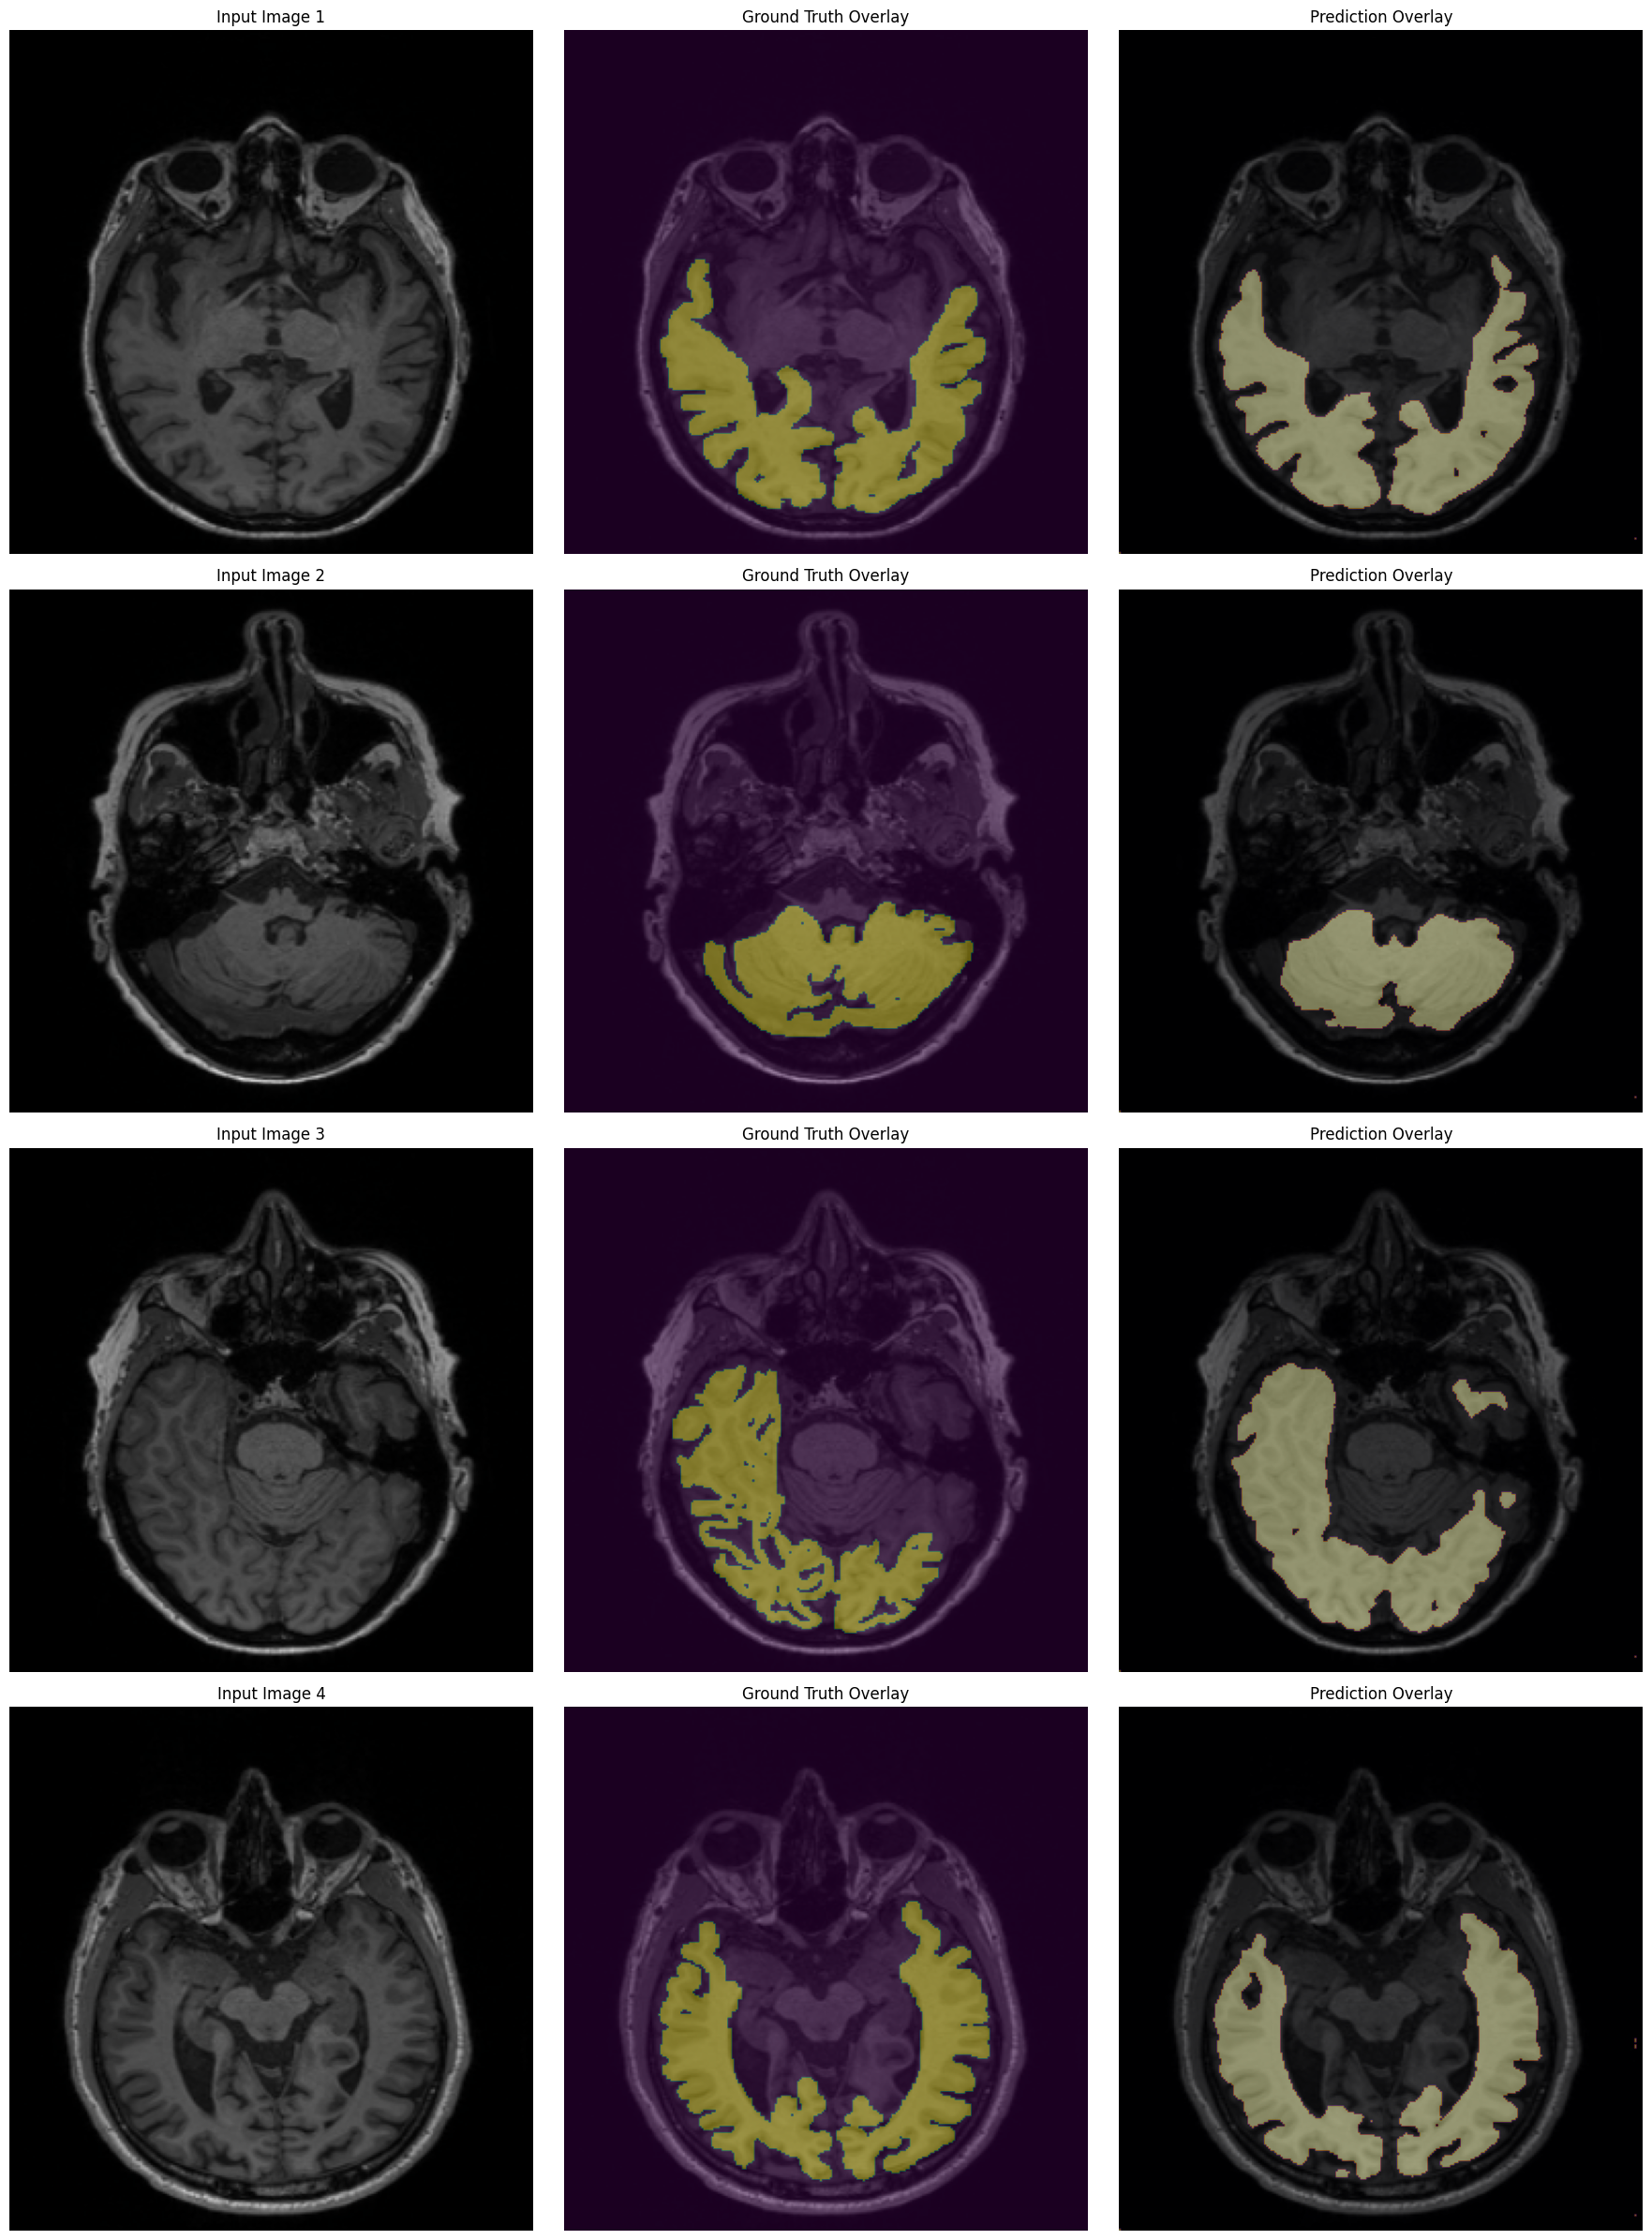

In [21]:
# 10. ENHANCED VISUALIZATION
# ====================================================
def denormalize_image(image):
    """Denormalize a tensor image for visualization."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.transpose(1, 2, 0) # C, H, W -> H, W, C
    image = (image * std + mean).clip(0, 1)
    return image

def plot_predictions(images, true_masks, pred_masks, n_samples=4):
    """Plots images with ground truth and prediction overlays."""
    plt.figure(figsize=(18, n_samples * 6))
    
    for i in range(n_samples):
        img_np = denormalize_image(images[i].cpu().numpy())
        true_mask_np = true_masks[i].cpu().numpy().squeeze()
        pred_mask_np = pred_masks[i].cpu().numpy().squeeze()

        # Input Image
        plt.subplot(n_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title(f"Input Image {i+1}")
        plt.axis('off')
        
        # Ground Truth Overlay
        plt.subplot(n_samples, 3, i * 3 + 2)
        plt.imshow(img_np)
        plt.imshow(true_mask_np, cmap='viridis', alpha=0.4)
        plt.title("Ground Truth Overlay")
        plt.axis('off')
        
        # Prediction Overlay
        plt.subplot(n_samples, 3, i * 3 + 3)
        plt.imshow(img_np)
        plt.imshow(pred_mask_np, cmap='inferno', alpha=0.4)
        plt.title("Prediction Overlay")
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f"{CFG.OUTPUT_DIR}prediction_visualizations.png", dpi=300)
    plt.show()

def visualize_best_model():
    print("\nVisualizing predictions from best model of Fold 1...")
    model_path = f"{CFG.OUTPUT_DIR}best_dice_fold_1.pth"
    if not os.path.exists(model_path):
        print("No saved model found for visualization.")
        return
        
    model = build_model()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    ds = BrainDataset(df_all.sample(16, random_state=CFG.seed), get_transforms('valid'))
    loader = DataLoader(ds, batch_size=4, shuffle=False)

    images, masks = next(iter(loader))
    
    with torch.no_grad():
        logits = model(images.to(CFG.device))
        preds = (logits.sigmoid() > 0.5).long()

    plot_predictions(images, masks, preds.cpu(), n_samples=min(4, len(images)))

visualize_best_model()

✅ Graphs saved to '/kaggle/working/outputs/final_kfold_metrics.png'


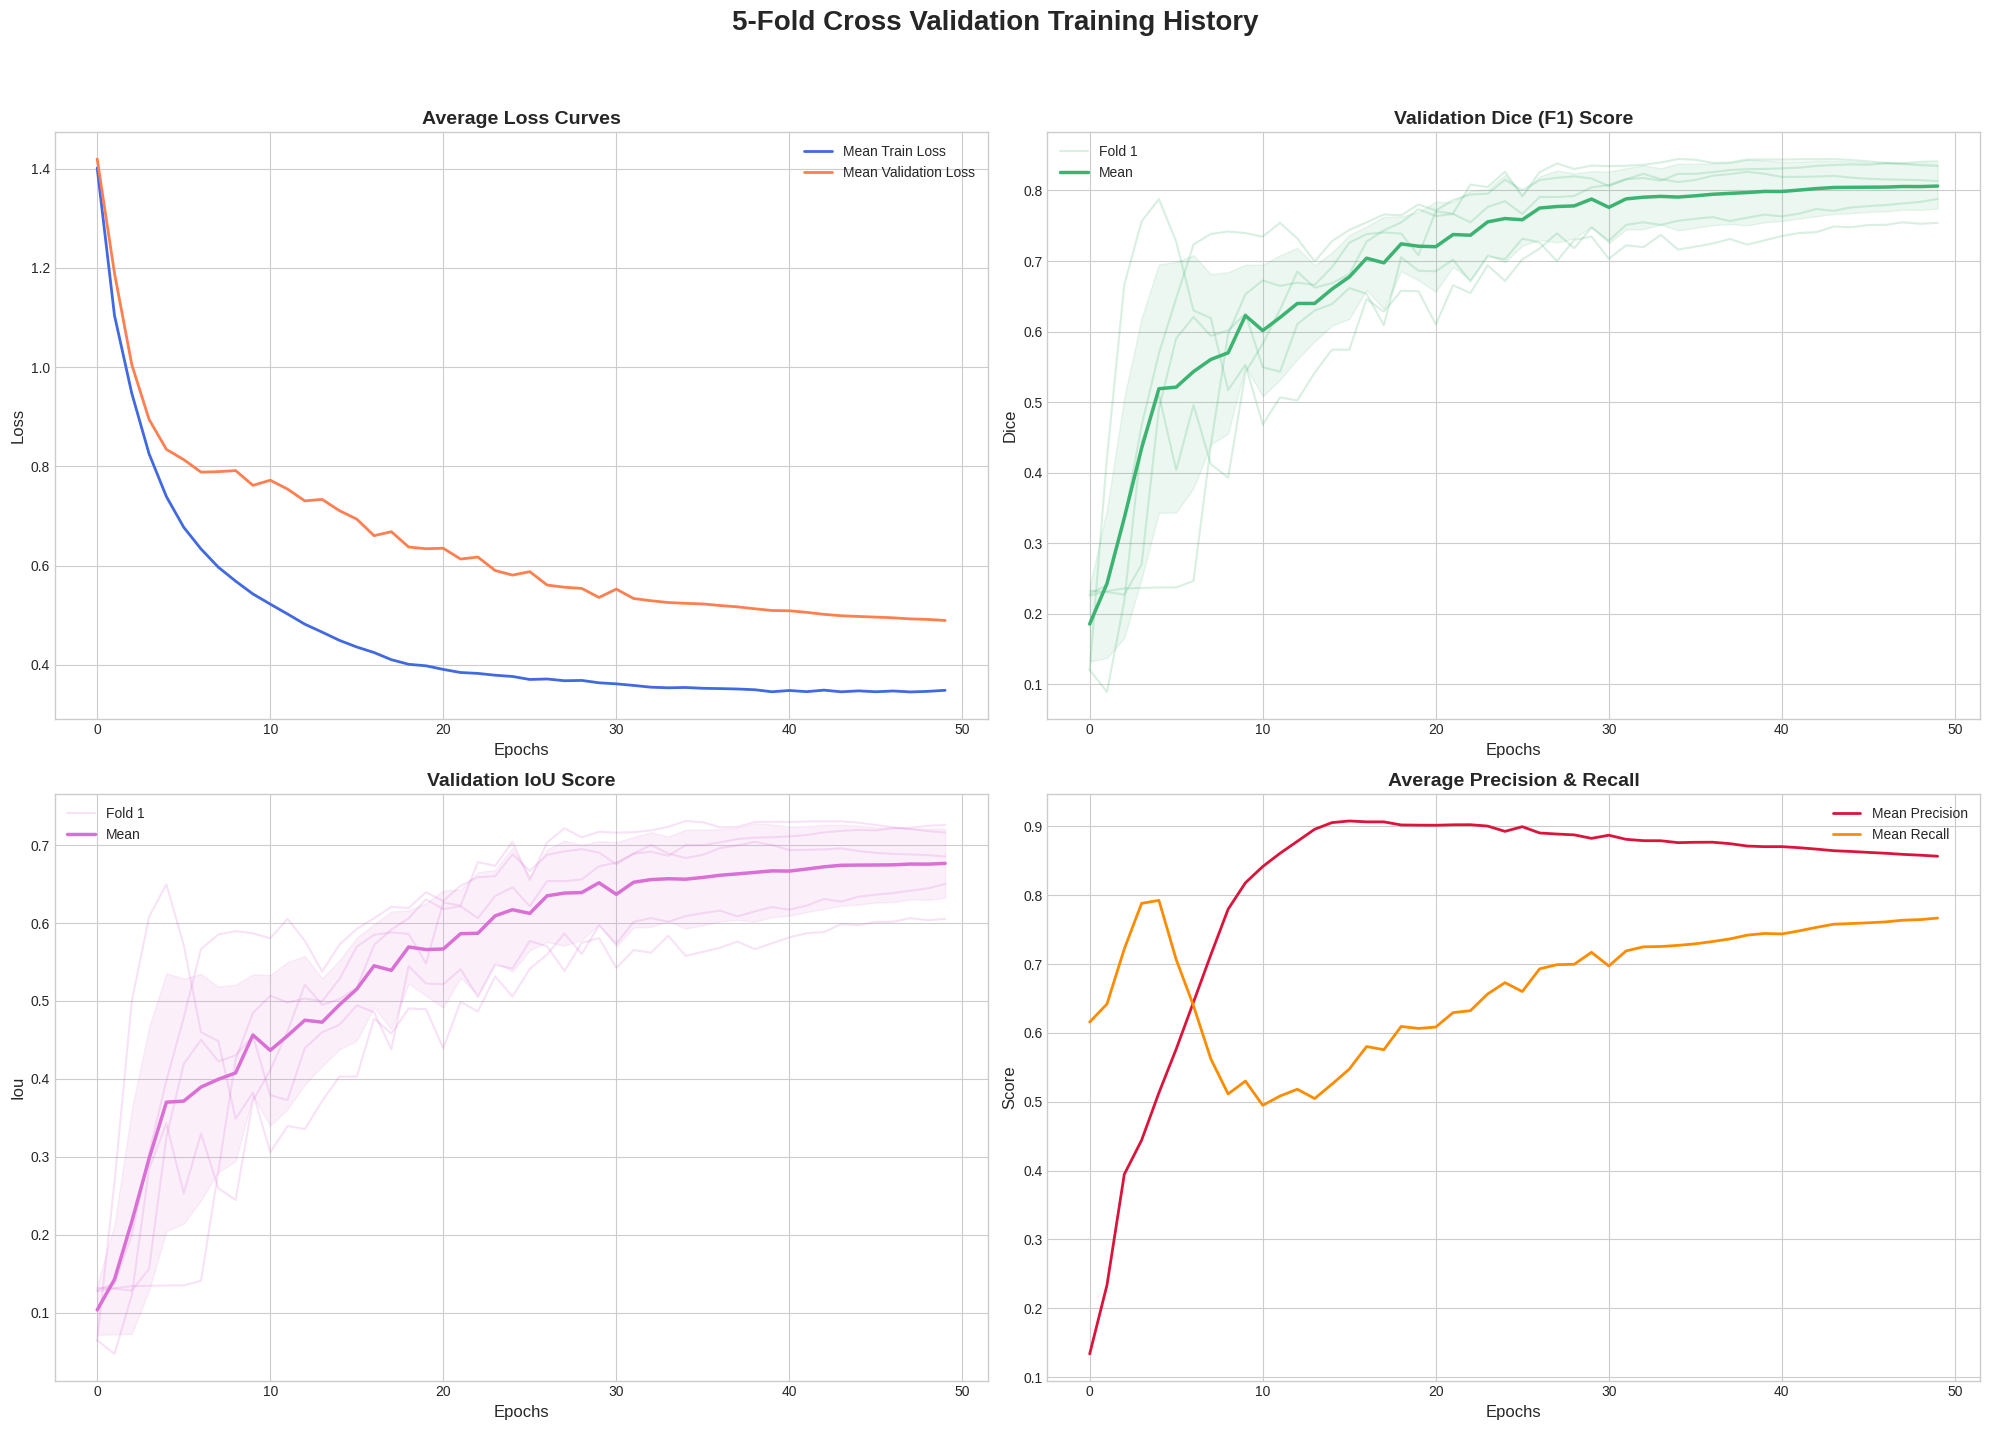

In [22]:
# ====================================================
# 11. K-FOLD HISTORY PLOTTING (COMPLETE)
# ====================================================
def plot_kfold_history(histories, output_dir=""):
    """
    Plots the training and validation metrics averaged over all folds.

    Args:
        histories (list of dict): A list where each element is a history
                                  dictionary from a single fold.
        output_dir (str): The directory to save the plot image.
    """
    if not histories:
        print("No history to plot.")
        return

    # Set a professional plot style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create a 2x2 grid for the plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(f'{len(histories)}-Fold Cross Validation Training History', fontsize=20, weight='bold')

    # --- Helper function to plot a metric for all folds and their mean ---
    def plot_metric(ax, metric_name, title, color):
        # Plot individual folds with transparency
        for i, history in enumerate(histories):
            ax.plot(
                history[metric_name],
                alpha=0.2,
                color=color,
                label=f'Fold {i+1}' if i == 0 else "_nolegend_" # Avoid duplicate labels
            )

        # Calculate and plot the mean line, making it thicker and more prominent
        all_runs = np.array([h[metric_name] for h in histories])
        mean_run = np.mean(all_runs, axis=0)
        std_run = np.std(all_runs, axis=0)
        
        ax.plot(mean_run, alpha=1.0, label='Mean', color=color, linewidth=2.5)
        # Add a shaded region for the standard deviation
        ax.fill_between(range(len(mean_run)), mean_run - std_run, mean_run + std_run, color=color, alpha=0.1)

        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel(metric_name.split('_')[-1].capitalize(), fontsize=12)
        ax.legend()

    # --- 1. Average Loss Curves (Train vs. Validation) ---
    ax = axes[0, 0]
    mean_train_losses = np.mean([h['train_loss'] for h in histories], axis=0)
    mean_val_losses = np.mean([h['val_loss'] for h in histories], axis=0)
    
    ax.plot(mean_train_losses, label='Mean Train Loss', color='royalblue', linewidth=2)
    ax.plot(mean_val_losses, label='Mean Validation Loss', color='coral', linewidth=2)
    ax.set_title('Average Loss Curves', fontsize=14, weight='bold')
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.legend()

    # --- 2. Validation Dice Score ---
    plot_metric(axes[0, 1], 'val_dice', 'Validation Dice (F1) Score', 'mediumseagreen')
    
    # --- 3. Validation IoU Score ---
    plot_metric(axes[1, 0], 'val_iou', 'Validation IoU Score', 'orchid')

    # --- 4. Validation Precision vs. Recall ---
    ax = axes[1, 1]
    mean_precision = np.mean([h['val_precision'] for h in histories], axis=0)
    mean_recall = np.mean([h['val_recall'] for h in histories], axis=0)

    ax.plot(mean_precision, label='Mean Precision', color='crimson', linewidth=2)
    ax.plot(mean_recall, label='Mean Recall', color='darkorange', linewidth=2)
    ax.set_title('Average Precision & Recall', fontsize=14, weight='bold')
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.legend()
    
    # Adjust layout to prevent titles from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the figure
    save_path = os.path.join(output_dir, "final_kfold_metrics.png")
    plt.savefig(save_path, dpi=300)
    print(f"✅ Graphs saved to '{save_path}'")
    
    plt.show()


# --- Final Call to the Function ---
# This line should be at the end of your script, after run_kfold() has finished.
plot_kfold_history(fold_histories, output_dir=CFG.OUTPUT_DIR)